<a href="https://colab.research.google.com/github/ShivarjunSarkar/Text-Analytics/blob/main/Lift%20%26%20MDS%20Analysis%20for%20the%20Automobile%20Sector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AUD F2021 Assignment 1 MSBA**
## **Authors:**  
### Shivarjun Sarkar [ss92758]
### Yash Warty [yvw57]
### Sahil Natu[sn25936]
### Divyansh Karki [dk27856] 
### Mahika Basal [mb62835]

In [ ]:
#Selenium is an open-source tool that automates web browsers.
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver 
#WebDriver is a browser automation framework that works with open source APIs. 
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

     |████████████████████████████████| 904 kB 5.1 MB/s 
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelea

# **Scrape Entry Level Luxury Performance Sedans Data**

URL: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans

In [ ]:
import pandas as pd
from tqdm import tqdm

wd = webdriver.Chrome('chromedriver',options=chrome_options)
comments = pd.DataFrame(columns = ['Date','comments'])

base_url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans'

wd.get(base_url)
pages = wd.find_elements_by_xpath('//*[@id="PagerBefore"]/a[8]')
total_pages = int(pages[0].text)
print('Total pages to scrape: ' + str(total_pages))
print('Pages scraped: ')

for page_number in tqdm(range(1,total_pages)):

  if page_number == 1:
    webpage = base_url
  else:
    webpage = base_url + '/p' + str(page_number)

  wd.get(webpage)

  ids = wd.find_elements_by_xpath("//*[contains(@id,'Comment_')]")

  comment_ids = []
  for i in ids:
    comment_ids.append(i.get_attribute('id'))
  
  #Loop through comments
  for x in comment_ids:
    #Extract dates from for each user on a page
    user_date = wd.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
    date = user_date.get_attribute('title')

    #Extract User Comments
    user_message = wd.find_elements_by_xpath('//*[@id="'+ x + '"]/div/div[3]/div/div[1]')
    comment = user_message[0].text

    #Remove BlockQuote
    blockquote = wd.find_elements_by_xpath('//*[@id="'+ x + '"]/div/div[3]/div/div[1]//descendant::blockquote')

    if len(blockquote) > 0:
      comment = comment.replace(blockquote[0].text,'').strip()
                                
    #Adding date, userid and comment for each user in a dataframe    
    comments.loc[len(comments)] = [date,comment]

#Save results to csv
comments.to_csv("results_edmunds.csv")
comments.head()

In [37]:
#Import & Download Required Libraries
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tag import pos_tag

import pandas as pd
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
import re
import math
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [38]:
#Read scraped data
scraped_file = 'https://raw.githubusercontent.com/ShivarjunSarkar/Text-Analytics/main/results_final_.csv'
comments = pd.read_csv(scraped_file, dtype=str)
comments.dropna(subset=['comments'],inplace=True)

## Filter out the most recent 5000 comments
comments = comments.tail(5000).reset_index(drop=True)
comments.head()

,Date,comments
0,"February 23, 2014 5:07AM",I've been gone for a while - new format and ba...
1,"February 23, 2014 8:08AM",I just earned a photogenic badge- yeAh - who a...
2,"February 23, 2014 2:30PM",Not Edmunds. Just part of the product they are...
3,"February 24, 2014 3:53PM",Re: BMW beer tap shifter. How do you feel abou...
4,"February 25, 2014 8:26AM",At least the Jaguar shifter is relatively easy...


# **Task A**
Once you fetch the data, test if the data support Zipf’s law. Plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization. 

In [39]:
#Tokenize and keep only words
all_tokens = nltk.word_tokenize(' '.join(comments['comments'].values))
all_tokens = [t.lower() for t in all_tokens if t.isalpha()]

#Word Frequency Table
word_freq = pd.DataFrame(all_tokens,columns=['tokens'])['tokens'].value_counts().reset_index().reset_index()
word_freq.rename(columns={"level_0": "rank", "index": "word", "tokens": "count"},inplace=True)
word_freq['rank']= word_freq['rank'].map(lambda x:x+1)
word_freq.head()

,rank,word,count
0,1,the,24222
1,2,a,11564
2,3,i,11046
3,4,to,10111
4,5,and,9900


In [40]:
perc20 = round(word_freq.loc[word_freq['rank']<=(0.2*word_freq['rank'].max()),'count'].sum()*100/word_freq['count'].sum())
print(f'The top 20% of words used accounts for {perc20}% of all words')
perc80 = round(word_freq.loc[word_freq['rank']>(0.2*word_freq['rank'].max()),'count'].sum()*100/word_freq['count'].sum())
print(f'The remaining 80% of words used accounts for {perc80}% of all words')

The top 20% of words used accounts for 93% of all words
The remaining 80% of words used accounts for 7% of all words


In [41]:
#Fit Regression Model - Empirical Testing of Zipf's Law
log_freq = word_freq.loc[:100,:].copy(deep=True)
log_freq['count'] = np.log(log_freq['count'])
log_freq['rank'] = np.log(log_freq['rank'])

y, X = dmatrices('count ~ rank', data=log_freq, return_type='dataframe')

model = sm.OLS(y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
y_pred = result.params['Intercept'] + result.params['rank'] * log_freq['rank']
print(f"Slope one the line is: {result.params['rank']}")

Slope one the line is: -0.8773688206077115


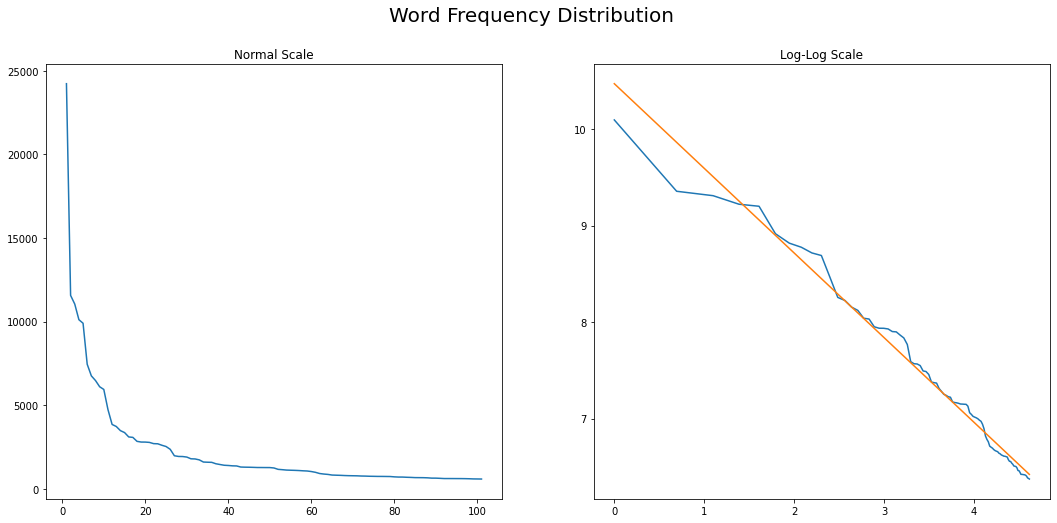

In [42]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18, 8)
fig.suptitle('Word Frequency Distribution', size=20)

ax[0].plot(word_freq.loc[:100,'rank'],word_freq.loc[:100,'count'])
ax[0].set_title('Normal Scale')

ax[1].plot(np.log(word_freq.loc[:100,'rank']),np.log(word_freq.loc[:100,'count']))
ax[1].plot(np.log(word_freq.loc[:100,'rank']), y_pred)
ax[1].set_title('Log-Log Scale')

fig.show()

# **Task B**
Find the top 10 brands from frequency counts. You will need to write a script to count the frequencies of words (stopwords should NOT be counted). Replace frequently occurring car models with brands so that from now on you have to deal with only brands and not models. You will need another script for this job. A list of model and brand names (not exhaustive) are provided in a separate file.   

**Step 1:** Import and display car models and brand data

In [43]:
carmodels_file = 'https://raw.githubusercontent.com/ShivarjunSarkar/Text-Analytics/main/car%20models%20and%20brands.csv'
car_models = pd.read_csv(carmodels_file)
display(car_models.head())
print('\n','Unique Car Brand\n')
print(car_models['Brand'].unique())

,Brand,Model
0,acura,integra
1,acura,legend
2,acura,vigor
3,acura,rlx
4,acura,ilx



 Unique Car Brand

['acura' 'audi' 'bmw' 'buick' 'cadillac' 'car' 'chevrolet' 'chrysler'
 'dodge' 'ford' 'honda' 'hyndai kia' 'hyundai' 'hyundai,' 'hyundai.'
 'infiniti' 'kia' 'kia,' 'kia.' 'lincoln' 'mazda' 'mercedes'
 'mercedes benz' 'mercedes-benz' 'mercury' 'mitsubishi' 'nissan' 'nissan.'
 'pontiac' 'problem' 'saturn' 'seat' 'sedan' 'subaru' 'suzuki' 'toyata'
 'toyota' 'volkswagen' 'volkwagen' 'volvo']


**Step 2:** Several brand have duplicate entries where the names are misspelled and some brands have different versions of the brand name entered. The following script cleans the brand names to respresent only unique brands.

In [44]:
def correct_brand(brand):
  '''Function to accept a brand name and clean it to give unqiue brand names for each brand'''

  if  'hyundai' in brand:
    return 'hyundai'
  elif 'kia' in brand:
    return 'kia'
  elif 'mercedes' in brand:
    return 'mercedes'
  elif 'nissan' in brand:
    return 'nissan'
  elif 'toyata' in brand:
    return 'toyota'
  elif 'volk' in brand:
    return 'volkswagen'
  else:
    return brand

#Clean brand names
car_models['Brand'] = car_models['Brand'].map(lambda x:correct_brand(x))
car_models = car_models[(car_models['Brand'] != 'problem') & (car_models['Brand'] != 'seat') & (car_models['Brand'] != 'car') & (car_models['Brand'] != 'sedan')]

#Display unique names
print(car_models['Brand'].unique())

['acura' 'audi' 'bmw' 'buick' 'cadillac' 'chevrolet' 'chrysler' 'dodge'
 'ford' 'honda' 'kia' 'hyundai' 'infiniti' 'lincoln' 'mazda' 'mercedes'
 'mercury' 'mitsubishi' 'nissan' 'pontiac' 'saturn' 'subaru' 'suzuki'
 'toyota' 'volkswagen' 'volvo']


**Step 3:** Tokenize comments, Replace models with name of their brands & Get unique tokens

In [45]:
#Create Dictionary for Models & Brands
model_brand = car_models.set_index('Model')
model_brand_dict = model_brand['Brand'].to_dict()

#Replace Car models with brand
stop = stopwords.words('english')
comments['comments'] = comments['comments'].astype(str)

#Tokenize only proper words, remove stop words and find unique words
comments['comments_tokens'] = comments['comments'].map(lambda comment: nltk.word_tokenize(re.sub(r'[^\w\s]',' ',comment.lower())))
comments['comments_tokens'] = comments['comments_tokens'].map(lambda comment: [word if word not in model_brand_dict else model_brand_dict[word] for word in comment])
comments['comments_tokens'] = comments['comments_tokens'].map(lambda words: [x for x in words if x not in stop ])
comments['comments_unique'] = comments['comments_tokens'].map(lambda x: sorted(set(x)))
comments.head()

,Date,comments,comments_tokens,comments_unique
0,"February 23, 2014 5:07AM",I've been gone for a while - new format and ba...,"[gone, new, format, badges, really, one, cool,...","[another, badges, better, change, cool, format..."
1,"February 23, 2014 8:08AM",I just earned a photogenic badge- yeAh - who a...,"[earned, photogenic, badge, yeah, marketing, n...","[badge, earned, format, marketing, new, photog..."
2,"February 23, 2014 2:30PM",Not Edmunds. Just part of the product they are...,"[edmunds, part, product, using, doubt, trying,...","[15, actually, come, cranky, differently, doub..."
3,"February 24, 2014 3:53PM",Re: BMW beer tap shifter. How do you feel abou...,"[bmw, beer, tap, shifter, feel, jag, hockey, p...","[beer, bmw, cool, feel, getting, hockey, jag, ..."
4,"February 25, 2014 8:26AM",At least the Jaguar shifter is relatively easy...,"[least, jaguar, shifter, relatively, easy, fig...","[able, although, aside, automatic, beer, bmw, ..."


**Step 4:** Rollup data to the brand level and get counts of each brand. Remove words which donot indicate a brand.

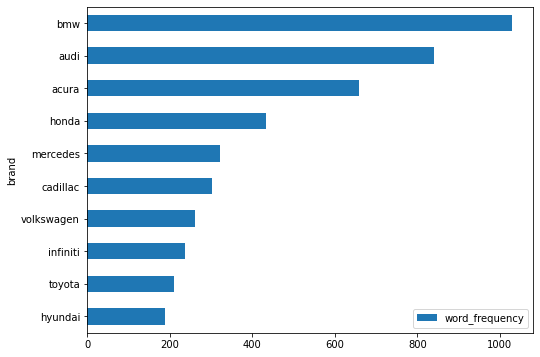

In [46]:
# Get frequency of all words
all_words = comments['comments_unique'].explode()
freq_dist = nltk.FreqDist(all_words)

# Filter out for just brands
all_brands_dict = {your_key: freq_dist[your_key] for your_key in freq_dist.keys() if your_key in model_brand_dict.values()}
all_brands = pd.DataFrame.from_dict(all_brands_dict, orient='index').reset_index()
all_brands.columns = ["brand","word_frequency"]
all_brands.sort_values("word_frequency", ascending= False, inplace=True)

# Display the top 10 brands by frequency count, but eliminating non-brands
top_brands = all_brands.head(10)

# Show bar plot of top brands
plt.rcParams["figure.figsize"] = (8,6)
top_brands.set_index('brand').plot(kind='barh')
fig = plt.gca().invert_yaxis()

# **Task C** 
Calculate lift ratios for associations between the top-10 brands identified in Task A. You will have to write a script to do this task). For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post.

**Step 1:** Get list of top brands

In [47]:
top_brands_list = list(top_brands['brand'])
top_brands_list

['bmw',
 'audi',
 'acura',
 'honda',
 'mercedes',
 'cadillac',
 'volkswagen',
 'infiniti',
 'toyota',
 'hyundai']

# Understanding the Lift Calculation Mechanism

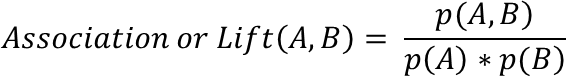

 ========================================================================================================



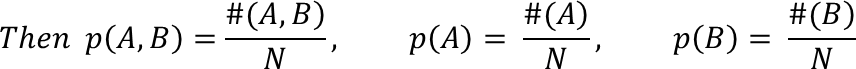



 ========================================================================================================

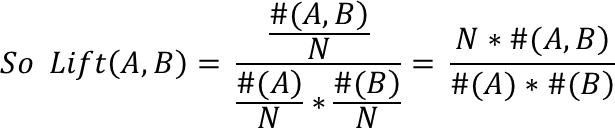

 ========================================================================================================

**Step 2:** Create a function to accept 2 words and calculate lift between them,

In [48]:
def Lift(Word1,Word2):
  CountA  = sum(comments['comments_unique'].map(lambda x: True if Word1 in x else False))
  CountB  = sum(comments['comments_unique'].map(lambda x: True if Word2 in x else False))
  CountAB = sum(comments['comments_unique'].map(lambda x: True if ((Word1 in x) and  (Word2 in x)) else False))
  N        = len(comments['comments_unique'])

  return (N * CountAB)/max(CountA * CountB,0)

Lift('suzuki','power')

0.0

In [49]:
#Create top Brand Column
brand_lift = pd.DataFrame(top_brands_list).rename(columns = {0:'brand'})
brand_lift['lift']=1

#Self merge for all combinations
brand_lift = brand_lift.merge(brand_lift,on='lift' , how='outer')
brand_lift = brand_lift.loc[brand_lift['brand_x']!=brand_lift['brand_y']]

#Calculate Lift for each brand combination & Sort
brand_lift['lift'] = brand_lift.apply(lambda x: Lift(x['brand_x'],x['brand_y']),axis=1)
brand_lift.sort_values(by='lift',ascending=False,inplace=True)
brand_lift[['brand_x','brand_y','lift']]

,brand_x,brand_y,lift
47,mercedes,infiniti,4.188591
74,infiniti,mercedes,4.188591
98,hyundai,toyota,3.884712
89,toyota,hyundai,3.884712
72,infiniti,acura,3.851541
...,...,...,...
65,volkswagen,cadillac,1.263839
30,honda,bmw,1.174444
3,bmw,honda,1.174444
62,volkswagen,acura,1.098774


# Task D
Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on GitHub). 

**Step 1**: Calculate Dissimilarity and cross tabulate the dissimilarity between brands

In [50]:
#Calculate Dissimilarity
brand_lift['dissimilarity']= 1/brand_lift['lift']

#Create table for Dissimilarity & replace inf with 1 indicating high dissimilarity
dissimilarity_graph = brand_lift.pivot_table(index = 'brand_x', columns='brand_y', values='dissimilarity').fillna(0)
dissimilarity_graph.replace([np.inf],1,inplace=True)
dissimilarity_graph

brand_y,acura,audi,bmw,cadillac,honda,hyundai,infiniti,mercedes,toyota,volkswagen
brand_x,,,,,,,,,,
acura,0.000000,0.515721,0.785896,0.504608,0.278097,0.643077,0.259636,0.419525,0.710769,0.910105
audi,0.515721,0.000000,0.508941,0.362400,0.552364,0.591111,0.341744,0.299600,0.551250,0.382748
bmw,0.785896,0.508941,0.000000,0.531726,0.851467,0.738491,0.485426,0.311915,0.665538,0.782203
cadillac,0.504608,0.362400,0.531726,0.000000,0.708476,0.546476,0.287504,0.262005,0.576545,0.791240
honda,0.278097,0.552364,0.851467,0.708476,0.000000,0.445730,0.480428,0.525713,0.284813,0.494383
hyundai,0.643077,0.591111,0.738491,0.546476,0.445730,0.000000,0.376833,0.508250,0.257419,0.497800
infiniti,0.259636,0.341744,0.485426,0.287504,0.480428,0.376833,0.000000,0.238744,0.499800,0.623560
mercedes,0.419525,0.299600,0.311915,0.262005,0.525713,0.508250,0.238744,0.000000,0.481500,0.580014
toyota,0.710769,0.551250,0.665538,0.576545,0.284813,0.257419,0.499800,0.481500,0.000000,0.458500


**Step 2:** Fit and transform the features to plot the MDS graph. 

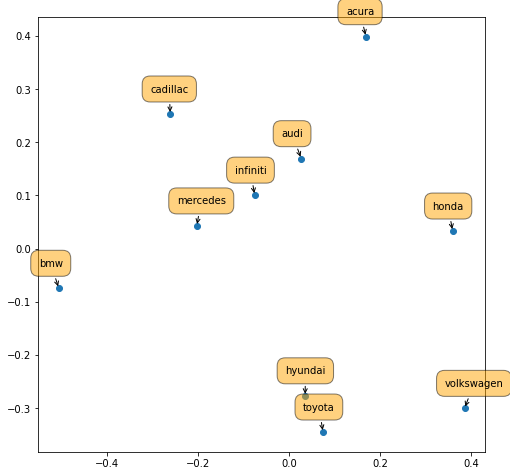

In [51]:
from sklearn.manifold import MDS

#Create Dissimiarity model, fit & transform
mds = MDS(dissimilarity='precomputed', random_state=0)
X =  mds.fit_transform(dissimilarity_graph)

#Plot points on MDS graph
plt.figure(figsize=(8,8))

coords = mds.embedding_

plt.scatter(coords[:, 0], coords[:, 1], marker = 'o')

for label, x, y in zip(dissimilarity_graph, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points',ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.8', fc = 'orange', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

# Task E
What insights can you offer to your client from your analyses in Tasks C and D 

# **Insights**
On reviewing our Lift Analysis and MDS Plot, we notice **two clear clusters of car brands that appear to be seperated by brand perception**. **Cluster 1** contains **premium brands like Mercedes, Infiniti, Audi and Cadillac**. On the other hand, **Cluster 2** contains **everyday brands like Honda, Toyota, Hyundai and Volkswagen**.

Based on the comments in the forums for entry-level luxury cars, we feel that **the brands should focus on competing for customers in the clusters mentioned** above rather than trying to acquire new customers by launching cheaper products. Due to the distance between clusters, it appears that the **customers have highly different preferences and will not easily switch clusters**. As a result, a lot of resources will be wasted with not enough conversions to justify such an effort.

Additionally, within** Cluster 1** based on the distances it appears that **Mercedes, Infiniti and Audi are close competitors**, while in **Cluster 2, Hyundai and Toyota are close competitors**. Hence, the companies should focus resources on exceeding one another on features, services and products offered rather that competing with every manufacturer in their segment.


# **Task F**
What are 5 most frequently mentioned attributes or features of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.

**Step 1:**  Perform POS tags and extract nouns

In [52]:
comments['pos'] = comments['comments_unique'].map(nltk.tag.pos_tag)
comments['nouns'] = comments['pos'].map(lambda pos_list: [x[0] for x in pos_list if x[1].startswith('NN')])
comments.head()

,Date,comments,comments_tokens,comments_unique,pos,nouns
0,"February 23, 2014 5:07AM",I've been gone for a while - new format and ba...,"[gone, new, format, badges, really, one, cool,...","[another, badges, better, change, cool, format...","[(another, DT), (badges, NNS), (better, VBP), ...","[badges, change, format, forum, graphicguy, se..."
1,"February 23, 2014 8:08AM",I just earned a photogenic badge- yeAh - who a...,"[earned, photogenic, badge, yeah, marketing, n...","[badge, earned, format, marketing, new, photog...","[(badge, NN), (earned, VBD), (format, JJ), (ma...","[badge, yeah]"
2,"February 23, 2014 2:30PM",Not Edmunds. Just part of the product they are...,"[edmunds, part, product, using, doubt, trying,...","[15, actually, come, cranky, differently, doub...","[(15, CD), (actually, RB), (come, VBN), (crank...","[cranky, edmunds, feature, ford, imo, improvem..."
3,"February 24, 2014 3:53PM",Re: BMW beer tap shifter. How do you feel abou...,"[bmw, beer, tap, shifter, feel, jag, hockey, p...","[beer, bmw, cool, feel, getting, hockey, jag, ...","[(beer, NN), (bmw, NN), (cool, NN), (feel, VBP...","[beer, bmw, cool, hockey, jag, puck, shifter, ..."
4,"February 25, 2014 8:26AM",At least the Jaguar shifter is relatively easy...,"[least, jaguar, shifter, relatively, easy, fig...","[able, although, aside, automatic, beer, bmw, ...","[(able, JJ), (although, IN), (aside, RB), (aut...","[beer, bmw, car, cars, controls, day, designer..."


**Step 2:** Get list of nouns and get the most frequent.

In [53]:
#Get all nouns
nouns = comments['nouns'].explode()

#Frequency Distribution of Nouns
nouns_df = pd.DataFrame.from_dict(nltk.FreqDist(nouns),orient='index').reset_index()

#Sort by count
nouns_df.sort_values(by=0,inplace=True,ascending=False)
nouns_df.reset_index(drop=True,inplace=True)
nouns_df[:30]

,index,0
0,car,1500
1,cars,926
2,bmw,733
3,time,614
4,acura,545
5,years,502
6,price,445
7,way,437
8,people,421
9,audi,381


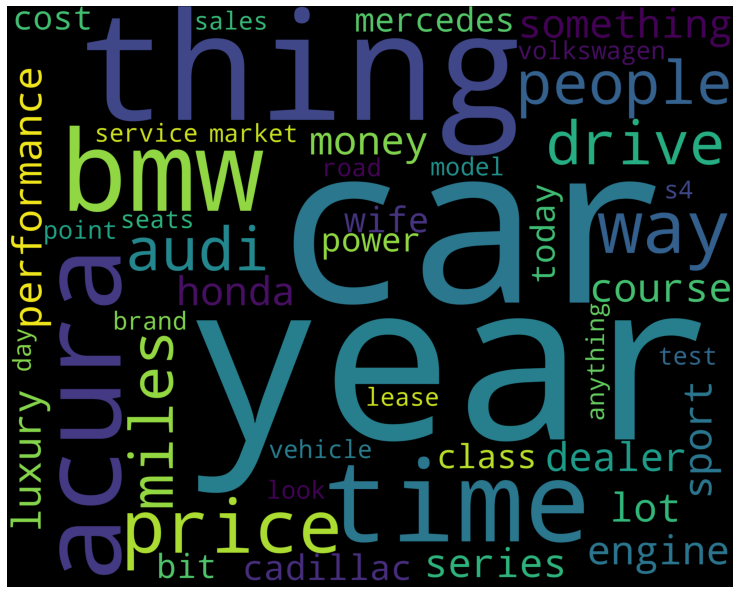

In [54]:
from wordcloud import WordCloud,STOPWORDS

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

wordcloud_draw(nouns_df.loc[:50,'index'])

The most important features in this segment seem to be:
**Price | Engine | Performance | Luxury | Power | Sport**

In [55]:
top_features = pd.Series(['price','engine','performance','luxury','power'])

In [56]:
#Create Features and brand dataframes
features_lift = pd.DataFrame(top_features).rename(columns = {0:'features'})
brands = pd.DataFrame(top_brands_list[:5]).rename(columns = {0:'brand'})

#Set Lift to 1
features_lift['lift']=1
brands['lift']=1

#Merge dataframes for all combinations between brands and features
features_lift = features_lift.merge(brands, on='lift', how='outer')

#Calculate lift for each feature-brand combination
features_lift['lift'] = features_lift.apply(lambda x: Lift(x['features'],x['brand']),axis=1)
features_lift.sort_values(by='lift',ascending=False,inplace=True)
features_lift.head(10)

,features,lift,brand
19,luxury,2.771588,mercedes
4,price,2.240190,mercedes
14,performance,2.196661,mercedes
11,performance,2.193987,audi
17,luxury,2.129839,acura
16,luxury,2.075919,audi
18,luxury,2.049953,honda
0,price,1.963565,bmw
21,power,1.943635,audi
1,price,1.939540,audi


In [57]:
#Top Brands by each feature
display(pd.DataFrame(features_lift.set_index('brand').groupby('features')['lift'].nlargest(4)))

lift
features    brand             
engine      acura     1.870265
            audi      1.804315
            honda     1.692108
            bmw       1.562500
luxury      mercedes  2.771588
            acura     2.129839
            audi      2.075919
            honda     2.049953
performance mercedes  2.196661
            audi      2.193987
            acura     1.893939
            bmw       1.867065
power       audi      1.943635
            bmw       1.743610
            honda     1.692843
            acura     1.669759
price       mercedes  2.240190
            bmw       1.963565
            audi      1.939540
            honda     1.786362

In [58]:
#Top Feature for each Brand
display(pd.DataFrame(features_lift.set_index('features').groupby('brand')['lift'].nlargest(4)))

lift
brand    features             
acura    luxury       2.129839
         performance  1.893939
         engine       1.870265
         power        1.669759
audi     performance  2.193987
         luxury       2.075919
         power        1.943635
         price        1.939540
bmw      price        1.963565
         performance  1.867065
         power        1.743610
         luxury       1.727533
honda    luxury       2.049953
         price        1.786362
         power        1.692843
         engine       1.692108
mercedes luxury       2.771588
         price        2.240190
         performance  2.196661
         power        1.589421

# **Task G:** 
What advice will you give to your client from Task F? For this assignment, you can assume that all sentiments are positive. 

# **Advice**
Based on POS tagging and frequency counts of the reviews, we found that the top five features are: Engine, Luxury, Performance, Power and Price. 

**Acura:**
The company tagline is "Precision Crafted Performance". In line with this, through the lift analysis Acura is most highly associated with luxury and performance. Hence, Acura is on the right path and should continue focusing on its strengths as the company vision is translating into positive reviews. 

**Audi:**
The company slogan is "Being ahead through Technology". In our analysis too, Audi is synonymous with performance since it has the highest lift for this feature amongst all brands while price is relatively lower. This is a good sign as it means that performance is top of mind for customers while discussing Audi and the company is promoting itself appropriately. 

**BMW:**
Contrary to Audi, Price is preeminent for customers while discussing BMW. Worryingly, Price is also has a higher lift than Performance and Power which are marketed by BMW as USP's. So the company needs to rethink its promotional strategy to change consumer perception in the long term for safeguarding sales. 

**Honda:**
Honda is most highly associated with luxury and price. This is a good sign for the company as an entry-level brand since customers perceive it to be value for money, offering luxury at an affordable price. This is a commendable achievement and the company should continue promoting this image to remain a formidable competitor in the entry-level luxury car segment. 

**Mercedes:**
Amongst all brands, Mercedes has the highest lift with both luxury and performance. This is outstanding, as it means the company is dominating the entry-level segment by targeting customers looking for both uxury offerings or drivers cars. However, the company should remain alert and adapt its strategy based on any changes made by competitors if it wishes to remain the frontrunner in the future too.


# **Task H:** 
Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?


In [59]:
#Median feature lift for each brand
features_lift.groupby('brand')['lift'].median().sort_values(ascending=False)

brand
mercedes    2.196661
audi        1.943635
acura       1.870265
bmw         1.743610
honda       1.692843
Name: lift, dtype: float64

In [60]:
## Read in the file with the aspirational words
aspiration_file = 'https://raw.githubusercontent.com/ShivarjunSarkar/Text-Analytics/main/aspiration.csv'
aspiration = pd.read_csv(aspiration_file)
aspiration.head()

,word
0,hope
1,hope to
2,prefer
3,really want
4,dream of


In [61]:
#Repalce all aspirational words with tthe word asporation
comments['comments_unique'] = comments['comments_unique'].map(lambda word_list: [word if word not in aspiration['word'] else 'aspiration' for word in word_list])
aspiration_df = top_brands[['brand']]

#Caculate lift between aspiration and brand
aspiration_df['lift'] = aspiration_df['brand'].map(lambda x: Lift(x,'aspiration'))
aspiration_df.sort_values(by='lift',ascending=False).head()

,brand,lift
8,infiniti,21.008403
15,volkswagen,19.083969
7,cadillac,16.556291
4,mercedes,15.576324
16,honda,11.520737


# **Analysis**
For finding the most aspirational brand, we have taken a set of aspiration-related words like "hope","dream","wish","aspire","dream car", etc. and then ran a lift analysis of these words for the top brands.

Based on this analysis, we concluded that Infiniti is the most aspirational brand for entry-level luxury cars as denoted by its high lift value. Using our domain knowledge, we can confirm this trend too. As the market moves towards SUV's from sedans, brands like Infiniti are top of mind for customers since they offer value for money and feature loaded luxury models like the QX50, QX55 and QX60. As younger customers enter the market, most envision graduating from an entry level Japanese sedan like Nissan (the parent company to Infiniti) to a premium crossover/SUV offering from Infiniti.